## A) Make multilayer graph of painters and their styles from WikiArt

https://github.com/jkbren/matplotlib-multilayer-network<br>
https://nbviewer.org/github/jkbren/matplotlib-multilayer-network/blob/master/matplotlib-multilayer-networks.ipynb

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d.art3d import Line3DCollection
%matplotlib inline

In [2]:
# let's start with the important stuff. pick your colors.
cols = ['steelblue', 'darksalmon', 'mediumseagreen']
np.random.seed(1)

In [3]:
# Imagine you have three node-aligned snapshots of a network
G1 = nx.karate_club_graph()
G2 = nx.karate_club_graph()
G3 = nx.karate_club_graph()

pos = nx.spring_layout(G1) # assuming common node location
graphs = [G1,G2, G3]

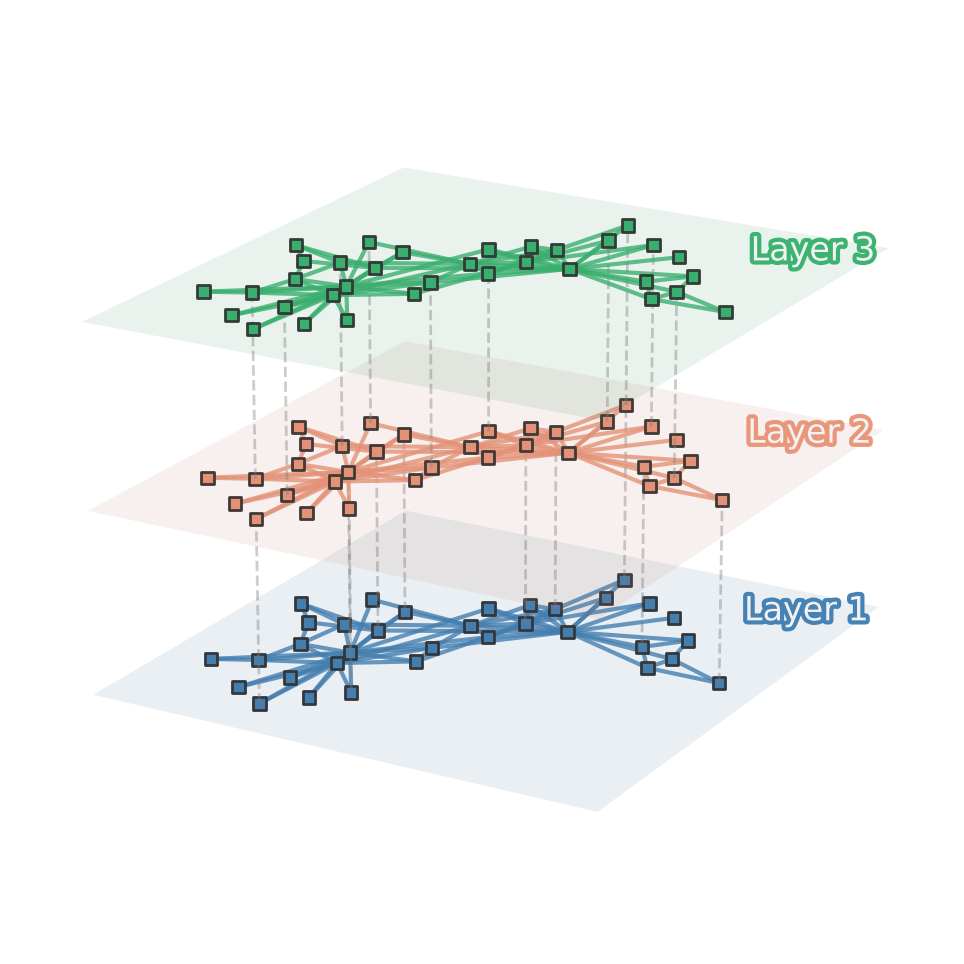

In [5]:
w = 8
h = 6

fig, ax = plt.subplots(1, 1, figsize=(w,h), dpi=200, subplot_kw={'projection':'3d'})

for gi, G in enumerate(graphs):
    # node positions
    xs = list(list(zip(*list(pos.values())))[0])
    ys = list(list(zip(*list(pos.values())))[1])
    zs = [gi]*len(xs) # set a common z-position of the nodes 

    # node colors
    cs = [cols[gi]]*len(xs)
    
    # if you want to have between-layer connections
    if gi > 0:
        thru_nodes = np.random.choice(list(G.nodes()),10,replace=False)
        lines3d_between = [(list(pos[i])+[gi-1],list(pos[i])+[gi]) for i in thru_nodes]
        between_lines = Line3DCollection(lines3d_between, zorder=gi, color='.5',
                                         alpha=0.4, linestyle='--', linewidth=1)
        ax.add_collection3d(between_lines)

    # add within-layer edges 
    lines3d = [(list(pos[i])+[gi],list(pos[j])+[gi]) for i,j in G.edges()]
    line_collection = Line3DCollection(lines3d, zorder=gi, color=cols[gi], alpha=0.8)
    ax.add_collection3d(line_collection)
    
    # now add nodes
    ax.scatter(xs, ys, zs, c=cs, edgecolors='.2', marker='s', alpha=1, zorder=gi+1)
    
    # add a plane to designate the layer
    xdiff = max(xs)-min(xs)
    ydiff = max(ys)-min(ys)
    ymin = min(ys)-ydiff*0.1
    ymax = max(ys)+ydiff*0.1
    xmin = min(xs)-xdiff*0.1 * (w/h)
    xmax = max(xs)+xdiff*0.1 * (w/h)
    xx, yy = np.meshgrid([xmin, xmax],[ymin, ymax])
    zz = np.zeros(xx.shape)+gi
    ax.plot_surface(xx, yy, zz, color=cols[gi], alpha=0.1, zorder=gi)

    # add label
    layertext = ax.text(0.0, 1.15, gi*0.95+0.5, "Layer %i"%(gi+1),
                        color='.95', fontsize='large', zorder=1e5, ha='left', va='center',
                        path_effects=[path_effects.Stroke(linewidth=3, foreground=cols[gi]),
                                      path_effects.Normal()])

# set them all at the same x,y,zlims
ax.set_ylim(min(ys)-ydiff*0.1,max(ys)+ydiff*0.1)
ax.set_xlim(min(xs)-xdiff*0.1,max(xs)+xdiff*0.1)
ax.set_zlim(-0.1, len(graphs) - 1 + 0.1)

# select viewing angle
angle = 30
height_angle = 20
ax.view_init(height_angle, angle)

# how much do you want to zoom into the fig
ax.dist = 8.5

ax.set_axis_off()

# plt.savefig('multilayer_network.png',dpi=425,bbox_inches='tight')
plt.show()


### PageRank / Wiki Connections:
The Python Class 6 notebook had a good example for PageRank

Wiki Connections: full dataset http://www.iesl.cs.umass.edu/data/data-wiki-links

smaller dataset: https://snap.stanford.edu/data/wikispeedia.html

## Network connection: Six Degrees of Francis Bacon
Network of the people connected to Francis Bacon, sadly the people in the set are mostly all born in the 16th century and are English so most philosophers in this list are not super relevant, there is no Kant, Nietzsche, etc.  But good example of a network

http://www.sixdegreesoffrancisbacon.com/?ids=10000473&min_confidence=60&type=network

<details><summary><u>Code for obtaining graph</u></summary>
<p>
    
```python
import igraph as ig #To install: conda install -c conda-forge python-igraph  
people = pd.read_csv('datasets/SDFB_people_.csv')
relationships = pd.read_csv('datasets/SDFB_relationships_.csv')

#I used igraph, because it's faster than networkx, and graph-tool sucks on Windows
network = relationships.rename(columns={'id': 'relationship_id', }).drop(columns=['created_by', 'approved_by', 'citation'])
print(network.head(), '\n')
cols = network.columns.tolist()
cols = cols[1:3] + cols[0:1] + cols[3:]
network = network[cols]
network = network[network['person1_index'] != 10050190] #for some reason, there is no person with this id, I did a loop
# I used the documentation here: https://python.igraph.org/en/stable/generation.html#from-pandas-dataframe-s  this I followed
# this is important too: https://python.igraph.org/en/stable/api/igraph.Graph.html#DataFrame  
g = ig.Graph.DataFrame(network, directed=False, vertices=people[['id', 'display_name','historical_significance','birth_year','death_year']], use_vids=False)
print(g.summary().replace(',', '\n'))
```
    
</p>
</details>

<details><summary><u>Code for filtering</u></summary>
<p>
    
```python
filtered = g.vs.select(_degree = 0) #https://python.igraph.org/en/stable/tutorial.html#selecting-vertices-and-edges
g.delete_vertices(filtered)

import cairo #Needed for plotting #import cairocffi as cairo  # can do matplotlib too
#layout = g.layout(layout='auto')
#ig.plot(g, layout = layout) #ig.plot(g) #looks even worse

```
    
</p>
</details>

<details><summary><u>Code for obtaining graph</u></summary>
<p>
    
```python
layout = g.layout(layout='reingold_tilford_circular') #kamada_kawai requires too much computing, 'fruchterman_reingold' is too dense
visual_style = {}
visual_style["vertex_size"] = 5
visual_style["vertex_color"] = "blue"
visual_style['bbox'] = (900, 900)
visual_style["layout"] = layout
#ig.plot(g, **visual_style) #Commented out because it takes big memory
# Needs improvement, but it's a start
```
    
</p>
</details>
